In [444]:
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt

In [445]:
data=pd.read_csv('I:/PG/Algorithm_Trading/history_Index_k_data.csv')

In [446]:
print(data.head())
print(data.dtypes)

         date       code    open    high     low    close  preclose  \
0  2005-01-04  sh.000300  994.77  994.77  980.66  982.794     0.000   
1  2005-01-05  sh.000300  981.58  997.32  979.88  992.564   982.794   
2  2005-01-06  sh.000300  993.33  993.79  980.33  983.174   992.564   
3  2005-01-07  sh.000300  983.05  995.71  979.81  983.958   983.174   
4  2005-01-10  sh.000300  983.76  993.96  979.79  993.879   983.958   

      volume        amount    pctChg  
0  741286894  4.431977e+09  0.000000  
1  711910898  4.529208e+09  0.994107  
2  628802905  3.921015e+09 -0.946036  
3  729869409  4.737469e+09  0.079741  
4  579169799  3.762933e+09  1.008277  
date         object
code         object
open        float64
high        float64
low         float64
close       float64
preclose    float64
volume        int64
amount      float64
pctChg      float64
dtype: object


In [447]:
#data needed is date/open/high/low/close from 2005.9.1-2012.3.15
data['date']=pd.to_datetime(data['date'])

In [448]:
print(data.dtypes)
print(data.head())

date        datetime64[ns]
code                object
open               float64
high               float64
low                float64
close              float64
preclose           float64
volume               int64
amount             float64
pctChg             float64
dtype: object
        date       code    open    high     low    close  preclose     volume  \
0 2005-01-04  sh.000300  994.77  994.77  980.66  982.794     0.000  741286894   
1 2005-01-05  sh.000300  981.58  997.32  979.88  992.564   982.794  711910898   
2 2005-01-06  sh.000300  993.33  993.79  980.33  983.174   992.564  628802905   
3 2005-01-07  sh.000300  983.05  995.71  979.81  983.958   983.174  729869409   
4 2005-01-10  sh.000300  983.76  993.96  979.79  993.879   983.958  579169799   

         amount    pctChg  
0  4.431977e+09  0.000000  
1  4.529208e+09  0.994107  
2  3.921015e+09 -0.946036  
3  4.737469e+09  0.079741  
4  3.762933e+09  1.008277  


In [449]:
#cut out data
df=data.loc[:,['date','open','high','low','close']]
#print(df.head(10))


In [450]:
#preprocessing the data
print(df.isnull().sum())
#no null

date     0
open     0
high     0
low      0
close    0
dtype: int64


In [451]:
#compute data
def kdjcompute(data,n,m,l,S):
    data['RSV']=(data['close']-data['low'].rolling(n).min())/(data['high'].rolling(n).max()-data['low'].rolling(n).min())*100
    data['K']=data['RSV'].fillna(data.loc[160,['RSV']]).ewm(alpha=1/m,adjust=False).mean()
    data['D']=data['K'].ewm(alpha=1/l,adjust=False).mean()
    data['J']=S*data['D']-(S-1)*data['K']
    return data

In [452]:
df1=kdjcompute(df,14,3,3,3)

In [401]:
#df1.head(25)

In [453]:
#strategy is that buying when k crosses 30 and 70 upwards and selling when k crosses 70 and 30 downwards
#0 indicates selling while 1 indicates buying 
def signalSet(data):
    data['pre_K']=data['K'].shift(1)
    data['pre_D']=data['D'].shift(1)
    #buying when k crosses 30 upwards
    index1=data[(data['pre_K']<30) & (data['K']>=30)].index
    data.loc[index1,'signal']=1
    #buying when k crosses 70 upwards
    index2=data[(data['pre_K']<70) & (data['K']>=70)].index
    data.loc[index2,'signal']=1
    #selling when k crosses 30 downwards
    index3=data[(data['pre_K']>30) & (data['K']<=30)].index
    data.loc[index3,'signal']=-1
    #selling when k crosses 70 downwards
    index4=data[(data['pre_K']>70) & (data['K']<=70)].index
    data.loc[index4,'signal']=-1
    return data

In [454]:
df1=signalSet(df1)

In [455]:
# compute position
def Position(data):
    df1['position'] = df1['signal'].fillna(method='ffill').shift(1)
    return data

In [457]:
#compute return
df1['return_daily']=(df1['close']-df1['close'].shift(1))/df['close']
df1=Position(df1)
df1.tail(25)

,date,open,high,low,close,RSV,K,D,J,pre_K,pre_D,signal,return_daily,position
4224,2022-05-26,3987.6815,4015.7468,3938.2389,3993.0446,67.722114,70.711537,73.891200,80.250526,72.206248,75.481031,NaN,0.002471,1.0
4225,2022-05-27,4022.7095,4051.1428,3983.3838,4001.2988,70.752296,70.725123,72.835841,77.057277,70.711537,73.891200,NaN,0.002063,1.0
4226,2022-05-30,4020.8584,4040.8190,4003.3768,4029.0179,68.407882,69.952709,71.874797,75.718972,70.725123,72.835841,-1.0,0.006880,1.0
4227,2022-05-31,4031.7621,4096.1971,4020.3781,4091.5176,97.119455,79.008291,74.252629,64.741303,69.952709,71.874797,1.0,0.015275,-1.0
4228,2022-06-01,4086.6177,4094.9008,4058.8468,4083.1772,91.985382,83.333988,77.279748,65.171269,79.008291,74.252629,NaN,-0.002043,1.0
4229,2022-06-02,4063.9996,4091.1520,4057.9135,4089.5682,95.919469,87.529148,80.696215,67.030348,83.333988,77.279748,NaN,0.001563,1.0
4230,2022-06-06,4090.5286,4166.6151,4063.9057,4166.0850,99.772362,91.610220,84.334217,69.782210,87.529148,80.696215,NaN,0.018367,1.0
4231,2022-06-07,4165.6899,4198.0863,4155.1683,4179.1285,92.828281,92.016240,86.894891,76.652193,91.610220,84.334217,NaN,0.003121,1.0
4232,2022-06-08,4187.1483,4224.8096,4158.0329,4219.8122,98.283060,94.105180,89.298321,79.684602,92.016240,86.894891,NaN,0.009641,1.0
4233,2022-06-09,4211.7225,4227.4484,4160.8814,4175.6747,82.098202,90.102854,89.566499,88.493787,94.105180,89.298321,NaN,-0.010570,1.0


In [458]:
#backtesting
#backtesting period is 2005-09-01 to 2012-3-15
#cut out dataset
print(df1[df1['date']=='2005-09-01'].index.to_list())
print(df1[df1['date']=='2012-03-15'].index.to_list())
df_test=df1.iloc[160:1748,:]
df_test=df_test.reset_index(drop=True)

[160]
[1747]


In [459]:
#no null
print(df_test['position'].isnull().sum())

0


In [460]:
#compute return of the holding period
df_test['return']=df_test['position']*df_test['return_daily']
df_test['cumuReturn']=(1+df_test['return']).cumprod()-1
df_test['cumuprice']=(1+df_test['cumuReturn'])*df_test['close']
df_test.tail()

,date,open,high,low,close,RSV,K,D,J,pre_K,pre_D,signal,return_daily,position,return,cumuReturn,cumuprice
1583,2012-03-09,2644.100,2664.414,2631.406,2664.302,82.563023,71.325133,71.926187,73.128294,65.706188,72.226714,1.0,0.010701,-1.0,-0.010701,7.365493,22288.200682
1584,2012-03-12,2663.243,2666.432,2636.423,2654.402,70.052655,70.900974,71.584449,72.951400,71.325133,71.926187,NaN,-0.003730,1.0,-0.003730,7.334293,22122.563914
1585,2012-03-13,2653.681,2681.334,2649.169,2681.073,86.993487,76.265145,73.144681,66.903753,70.900974,71.584449,NaN,0.009948,1.0,0.009948,7.417202,22567.131769
1586,2012-03-14,2694.475,2705.754,2595.342,2605.106,9.834626,54.121639,66.803667,92.167723,76.265145,73.144681,-1.0,-0.029161,1.0,-0.029161,7.171749,21288.272671
1587,2012-03-15,2602.661,2618.252,2575.437,2585.546,7.757238,38.666838,57.424724,94.940495,54.121639,66.803667,NaN,-0.007565,-1.0,0.007565,7.233569,21288.272671


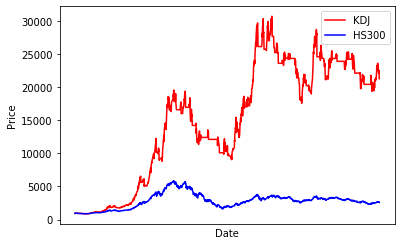

In [409]:
#plot
KDJ=df_test['cumuprice'].to_list()
date=df_test['date'].values.reshape(-1,1)
HS300=df_test['close'].to_list()

plt.plot(date,KDJ,c='red',label='KDJ')
plt.plot(date,HS300,c='blue',label='HS300')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks([])

plt.show()

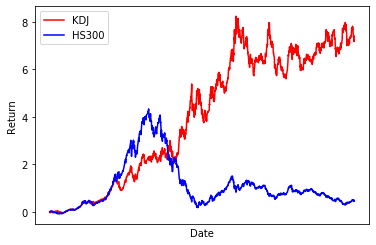

In [461]:
#plot
KDJ_return=df_test['cumuReturn'].to_list()
HS300_return=((df_test['return_daily']+1).cumprod()-1).to_list()

plt.plot(date,KDJ_return,c='red',label='KDJ')
plt.plot(date,HS300_return,c='blue',label='HS300')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks([])

plt.show()

In [462]:
#strategy optimization
#Buying when K crosses 30 upwards, selling when K crosses 70 downwards
#Selling when the signal is 1 and K is below 70, buying when the signal is -1 and K is above 30
#Buying When K is above 70
def signalSetOpt(data):
    #buying when k crosses 30 upwards
    index5=data[(data['pre_K']<30) & (data['K']>=30)].index
    data.loc[index5,'opt_signal']=1
    #selling when k crosses 70 downwards
    index4=data[(data['pre_K']>70) & (data['K']<=70)].index
    data.loc[index4,'opt_signal']=-1
    #Selling when the signal is 1 and K is below 70
    index1=data[(data['K']<70) & (data['signal']==1)& (data['K']<data['D']) & (data['pre_K']>=data['pre_D'])].index
    data.loc[index1,'opt_signal']=-1
    #Buying when the signal is -1 and K is above 30
    index2=data[(data['K']>30) & (data['signal']==-1)&(data['K']>=data['D']) & (data['pre_K']<data['pre_D'])].index
    data.loc[index2,'opt_signal']=1
    #Buying when K is above 70
    index3=data[data['K']>70].index
    data.loc[index3,'opt_signal']=1
    return data

In [463]:
df2=signalSetOpt(df1)

In [464]:
df2

,date,open,high,low,close,RSV,K,D,J,pre_K,pre_D,signal,return_daily,position,opt_signal
0,2005-01-04,994.7700,994.7700,980.6600,982.7940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-05,981.5800,997.3200,979.8800,992.5640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009843,NaN,NaN
2,2005-01-06,993.3300,993.7900,980.3300,983.1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009551,NaN,NaN
3,2005-01-07,983.0500,995.7100,979.8100,983.9580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000797,NaN,NaN
4,2005-01-10,983.7600,993.9600,979.7900,993.8790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009982,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,2022-06-24,4354.5530,4400.6852,4346.1221,4394.7723,98.014181,88.835768,85.883355,79.978528,84.246562,84.407148,NaN,0.011581,1.0,1.0
4245,2022-06-27,4414.3321,4472.6948,4414.3321,4444.2639,92.311106,89.994214,87.253641,81.772496,88.835768,85.883355,NaN,0.011136,1.0,1.0
4246,2022-06-28,4442.5811,4497.8949,4407.3519,4490.5166,98.131915,92.706781,89.071355,81.800502,89.994214,87.253641,NaN,0.010300,1.0,1.0
4247,2022-06-29,4472.7346,4503.1307,4413.9961,4421.3570,79.566878,88.326814,88.823174,89.815896,92.706781,89.071355,NaN,-0.015642,1.0,1.0


In [465]:
#compute position
df2['opt_position'] = df2['opt_signal'].fillna(method='ffill').shift(1)

In [466]:
df2

,date,open,high,low,close,RSV,K,D,J,pre_K,pre_D,signal,return_daily,position,opt_signal,opt_position
0,2005-01-04,994.7700,994.7700,980.6600,982.7940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-05,981.5800,997.3200,979.8800,992.5640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009843,NaN,NaN,NaN
2,2005-01-06,993.3300,993.7900,980.3300,983.1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009551,NaN,NaN,NaN
3,2005-01-07,983.0500,995.7100,979.8100,983.9580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000797,NaN,NaN,NaN
4,2005-01-10,983.7600,993.9600,979.7900,993.8790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009982,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,2022-06-24,4354.5530,4400.6852,4346.1221,4394.7723,98.014181,88.835768,85.883355,79.978528,84.246562,84.407148,NaN,0.011581,1.0,1.0,1.0
4245,2022-06-27,4414.3321,4472.6948,4414.3321,4444.2639,92.311106,89.994214,87.253641,81.772496,88.835768,85.883355,NaN,0.011136,1.0,1.0,1.0
4246,2022-06-28,4442.5811,4497.8949,4407.3519,4490.5166,98.131915,92.706781,89.071355,81.800502,89.994214,87.253641,NaN,0.010300,1.0,1.0,1.0
4247,2022-06-29,4472.7346,4503.1307,4413.9961,4421.3570,79.566878,88.326814,88.823174,89.815896,92.706781,89.071355,NaN,-0.015642,1.0,1.0,1.0


In [467]:
df_test2=df2.iloc[160:1748,:]
df_test2=df_test2.reset_index(drop=True)

In [468]:
df_test2

,date,open,high,low,close,RSV,K,D,J,pre_K,pre_D,signal,return_daily,position,opt_signal,opt_position
0,2005-09-01,928.520,944.947,926.060,944.559,69.987820,43.051984,38.710652,30.027986,29.584067,36.539985,1.0,0.017620,-1.0,1.0,-1.0
1,2005-09-02,945.978,947.918,941.314,947.871,76.711328,54.271766,43.897690,23.149538,43.051984,38.710652,NaN,0.003494,1.0,NaN,1.0
2,2005-09-05,949.077,952.985,944.629,952.717,91.180119,66.574550,51.456643,21.220829,54.271766,43.897690,NaN,0.005087,1.0,NaN,1.0
3,2005-09-06,953.410,956.297,934.972,936.610,56.732538,63.293879,55.402388,39.619407,66.574550,51.456643,NaN,-0.017197,1.0,NaN,1.0
4,2005-09-07,934.991,952.896,932.648,952.758,92.342147,72.976635,61.260471,37.828142,63.293879,55.402388,1.0,0.016949,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,2012-03-09,2644.100,2664.414,2631.406,2664.302,82.563023,71.325133,71.926187,73.128294,65.706188,72.226714,1.0,0.010701,-1.0,1.0,-1.0
1584,2012-03-12,2663.243,2666.432,2636.423,2654.402,70.052655,70.900974,71.584449,72.951400,71.325133,71.926187,NaN,-0.003730,1.0,1.0,1.0
1585,2012-03-13,2653.681,2681.334,2649.169,2681.073,86.993487,76.265145,73.144681,66.903753,70.900974,71.584449,NaN,0.009948,1.0,1.0,1.0
1586,2012-03-14,2694.475,2705.754,2595.342,2605.106,9.834626,54.121639,66.803667,92.167723,76.265145,73.144681,-1.0,-0.029161,1.0,-1.0,1.0


In [469]:
#compute return of the holding period
df_test2['opt_return']=df_test2['opt_position']*df_test2['return_daily']
df_test2['opt_cumuReturn']=(1+df_test2['opt_return']).cumprod()-1

In [472]:
df_test2

,date,open,high,low,close,RSV,K,D,J,pre_K,pre_D,signal,return_daily,position,opt_signal,opt_position,opt_return,opt_cumuReturn
0,2005-09-01,928.520,944.947,926.060,944.559,69.987820,43.051984,38.710652,30.027986,29.584067,36.539985,1.0,0.017620,-1.0,1.0,-1.0,-0.017620,-0.017620
1,2005-09-02,945.978,947.918,941.314,947.871,76.711328,54.271766,43.897690,23.149538,43.051984,38.710652,NaN,0.003494,1.0,NaN,1.0,0.003494,-0.014187
2,2005-09-05,949.077,952.985,944.629,952.717,91.180119,66.574550,51.456643,21.220829,54.271766,43.897690,NaN,0.005087,1.0,NaN,1.0,0.005087,-0.009173
3,2005-09-06,953.410,956.297,934.972,936.610,56.732538,63.293879,55.402388,39.619407,66.574550,51.456643,NaN,-0.017197,1.0,NaN,1.0,-0.017197,-0.026212
4,2005-09-07,934.991,952.896,932.648,952.758,92.342147,72.976635,61.260471,37.828142,63.293879,55.402388,1.0,0.016949,1.0,1.0,1.0,0.016949,-0.009708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,2012-03-09,2644.100,2664.414,2631.406,2664.302,82.563023,71.325133,71.926187,73.128294,65.706188,72.226714,1.0,0.010701,-1.0,1.0,-1.0,-0.010701,5.884812
1584,2012-03-12,2663.243,2666.432,2636.423,2654.402,70.052655,70.900974,71.584449,72.951400,71.325133,71.926187,NaN,-0.003730,1.0,1.0,1.0,-0.003730,5.859134
1585,2012-03-13,2653.681,2681.334,2649.169,2681.073,86.993487,76.265145,73.144681,66.903753,70.900974,71.584449,NaN,0.009948,1.0,1.0,1.0,0.009948,5.927368
1586,2012-03-14,2694.475,2705.754,2595.342,2605.106,9.834626,54.121639,66.803667,92.167723,76.265145,73.144681,-1.0,-0.029161,1.0,-1.0,1.0,-0.029161,5.725361


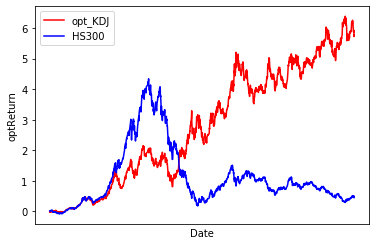

In [473]:
#plot
opt_KDJ_return=df_test2['opt_cumuReturn'].to_list()

plt.plot(date,opt_KDJ_return,c='red',label='opt_KDJ')
plt.plot(date,HS300_return,c='blue',label='HS300')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('optReturn')
plt.xticks([])

plt.show()